<a href="https://colab.research.google.com/github/dhanush852/intro_to-ml/blob/main/ML6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [26]:
df = pd.read_csv('/content/Housing.csv')

# Display the first 5 rows of the DataFrame
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [27]:
df['furnishingstatus'].value_counts().unique
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=False).drop('furnishingstatus_semi-furnished', axis=1)
binary_columns = df.select_dtypes(include=['object']).columns
df[binary_columns] = df[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))
df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


In [28]:
df.shape

(545, 14)

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
scaler_x, scaler_y = MinMaxScaler(), MinMaxScaler()

X = pd.DataFrame(scaler_x.fit_transform(df.drop('price', axis=1)), columns=df.drop('price', axis=1).columns)
y = pd.DataFrame(scaler_y.fit_transform(df[['price']]), columns=['price'])

train_X, val_X, train_Y, val_Y = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

X_train, y_train = torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_Y, dtype=torch.float32)
X_val, y_val = torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_Y, dtype=torch.float32)



In [42]:
train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=32)


<ipython-input-42-1245f3f52f9e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
<ipython-input-42-1245f3f52f9e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=32)


In [43]:
def model_train(model, criterion, optimizer, epochs, train_loader, X_val, y_val):
    loss_train = []
    loss_val = []
    for epoch in range(epochs + 1):
        # Training
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            if epoch % 500 == 0:
              print(f'Epoch {epoch}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')
              loss_val.append(val_loss)
              loss_train.append(loss)
    return loss_train, loss_val


## **Part 1.A**

In [45]:
# Model 1
model1 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 1)
)  # Removed .to(torch.float64) to keep it in Float precision
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
train_loss, val_loss = model_train(model1, nn.MSELoss(), optimizer1, 5000, train_loader, X_val, y_val)


Epoch 0/5000, Training Loss: 0.10039403289556503, Validation Loss: 0.07903138548135757
Epoch 500/5000, Training Loss: 0.005294686183333397, Validation Loss: 0.01319195982068777
Epoch 1000/5000, Training Loss: 0.007409542798995972, Validation Loss: 0.013190061785280704
Epoch 1500/5000, Training Loss: 0.008349657990038395, Validation Loss: 0.013185414485633373
Epoch 2000/5000, Training Loss: 0.003512619063258171, Validation Loss: 0.013208026066422462
Epoch 2500/5000, Training Loss: 0.004578852094709873, Validation Loss: 0.013171275146305561
Epoch 3000/5000, Training Loss: 0.009650250896811485, Validation Loss: 0.013167105615139008
Epoch 3500/5000, Training Loss: 0.0048214527778327465, Validation Loss: 0.013194478116929531
Epoch 4000/5000, Training Loss: 0.0055327266454696655, Validation Loss: 0.013156761415302753
Epoch 4500/5000, Training Loss: 0.0038597634993493557, Validation Loss: 0.013265423476696014
Epoch 5000/5000, Training Loss: 0.003908403217792511, Validation Loss: 0.01325360033

In [47]:
for name, param in model1.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([1, 32])
Parameter name: 2.bias, Shape: torch.Size([1])


In [48]:
total_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')

Total number of trainable parameters  481 



In [49]:
epochs = range(0, 5001, 500)
epochs

range(0, 5001, 500)

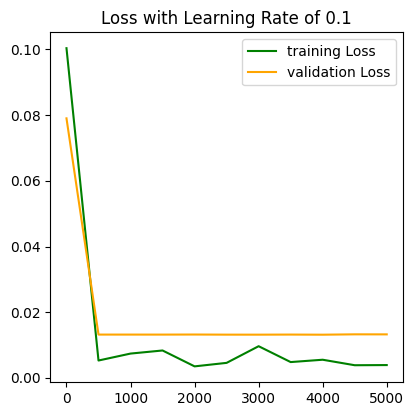

In [51]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.plot(epochs, [item.detach().item() for item in train_loss], 'green', label='training Loss')
plt.plot(epochs, [item.detach().item() for item in val_loss], 'orange', label='validation Loss'); plt.title('Loss with Learning Rate of 0.1'); plt.legend(); plt.show()


## **PART 1.B**

In [54]:
model2 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 64),  # Second hidden layer with 64 neurons
    nn.Tanh(),
    nn.Linear(64, 16),  # Third hidden layer with 16 neurons
    nn.Tanh(),
    nn.Linear(16, 1)   # Output layer with 1 neuron
)  # Removed .to(torch.float64) to keep it in Float precision
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
criterion = nn.MSELoss()
train_loss_2, val_loss_2 = model_train(model2, criterion, optimizer2, 5000, train_loader, X_val, y_val)


Epoch 0/5000, Training Loss: 0.02586529031395912, Validation Loss: 0.03866295889019966
Epoch 500/5000, Training Loss: 0.007458447478711605, Validation Loss: 0.013624352402985096
Epoch 1000/5000, Training Loss: 0.005985305178910494, Validation Loss: 0.013579562306404114
Epoch 1500/5000, Training Loss: 0.0046053375117480755, Validation Loss: 0.013443274423480034
Epoch 2000/5000, Training Loss: 0.006932082585990429, Validation Loss: 0.013440541923046112
Epoch 2500/5000, Training Loss: 0.005910057574510574, Validation Loss: 0.01343543455004692
Epoch 3000/5000, Training Loss: 0.008261363953351974, Validation Loss: 0.013386903330683708
Epoch 3500/5000, Training Loss: 0.003944695461541414, Validation Loss: 0.013340742327272892
Epoch 4000/5000, Training Loss: 0.005746741313487291, Validation Loss: 0.013425524346530437
Epoch 4500/5000, Training Loss: 0.006176352966576815, Validation Loss: 0.01339021697640419
Epoch 5000/5000, Training Loss: 0.004538550972938538, Validation Loss: 0.01340117771178

In [55]:
for name, param in model2.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([64, 32])
Parameter name: 2.bias, Shape: torch.Size([64])
Parameter name: 4.weight, Shape: torch.Size([16, 64])
Parameter name: 4.bias, Shape: torch.Size([16])
Parameter name: 6.weight, Shape: torch.Size([1, 16])
Parameter name: 6.bias, Shape: torch.Size([1])


In [56]:
total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')

Total number of trainable parameters  3617 



<ipython-input-57-13cacacf0b85>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


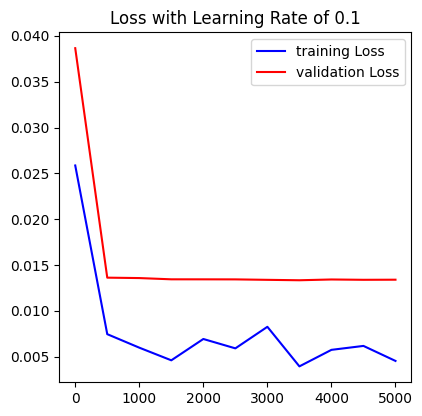

In [57]:
plt.figure(figsize=(10, 10))
plt.title('Loss for optimizer - SGD')

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss_2]), color='blue', label = 'training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss_2]), color='red', label = 'validation Loss')
plt.title('Loss with Learning Rate of 0.1')
plt.legend()

plt.show()

## **PART 2.1**

In [58]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00
time: 3.31 ms (started: 2023-12-02 01:02:27 +00:00)


In [59]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

time: 331 ms (started: 2023-12-02 01:02:46 +00:00)


In [60]:
torch.manual_seed(123)

time: 7.94 ms (started: 2023-12-02 01:03:11 +00:00)


In [61]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:02<00:00, 80440440.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
time: 21.4 s (started: 2023-12-02 01:03:32 +00:00)


In [62]:
mean

tensor([0.4914, 0.4822, 0.4465])

time: 20.5 ms (started: 2023-12-02 01:05:53 +00:00)


In [63]:
std

tensor([0.2470, 0.2435, 0.2616])

time: 4.53 ms (started: 2023-12-02 01:05:59 +00:00)


In [64]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


time: 718 µs (started: 2023-12-02 01:06:16 +00:00)


In [65]:
device

device(type='cpu')

time: 3.76 ms (started: 2023-12-02 01:06:26 +00:00)


In [66]:
# Define transformation with calculated mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR10 datasets
cifar10 = datasets.CIFAR10('./data', train=True, download=False, transform=transform)
cifar10_val = datasets.CIFAR10('./data', train=False, download=False, transform=transform)


time: 1.07 s (started: 2023-12-02 01:12:09 +00:00)


In [68]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 512),
    nn.Tanh(),
    nn.Linear(512, 10)
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

time: 19.1 ms (started: 2023-12-02 01:12:56 +00:00)


In [71]:
def train_model(model, train_loader, test_loader, num_epochs=300, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Testing the model
        model.eval()
        correct = 0
        total = 0
        all_predicted = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predicted.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct / total

        if epoch % 1 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Test Accuracy: {accuracy * 100:.2f}%')

    # Classification Report
    report = classification_report(all_labels, all_predicted)
    print("Classification Report:\n", report)


time: 3.24 ms (started: 2023-12-02 01:15:00 +00:00)


In [72]:
train_model(model, train_loader, test_loader, num_epochs=300, lr=0.01)

Epoch 1/300, Loss: 1.6521172705020037, Test Accuracy: 43.15%
Epoch 2/300, Loss: 1.5804378465437692, Test Accuracy: 44.45%
Epoch 3/300, Loss: 1.5198366514246813, Test Accuracy: 45.26%
Epoch 4/300, Loss: 1.4625313013544161, Test Accuracy: 46.44%
Epoch 5/300, Loss: 1.4085316710646, Test Accuracy: 47.50%
Epoch 6/300, Loss: 1.3539841107580803, Test Accuracy: 47.11%
Epoch 7/300, Loss: 1.3031534532744078, Test Accuracy: 47.23%
Epoch 8/300, Loss: 1.249340126015632, Test Accuracy: 48.36%
Epoch 9/300, Loss: 1.1990976107097633, Test Accuracy: 47.90%
Epoch 10/300, Loss: 1.147438968516891, Test Accuracy: 48.39%
Epoch 11/300, Loss: 1.0958708692496966, Test Accuracy: 49.10%
Epoch 12/300, Loss: 1.0460041413990564, Test Accuracy: 48.73%
Epoch 13/300, Loss: 0.9943198018247931, Test Accuracy: 48.12%
Epoch 14/300, Loss: 0.9466876947223873, Test Accuracy: 48.06%
Epoch 15/300, Loss: 0.8974496146195681, Test Accuracy: 48.03%
Epoch 16/300, Loss: 0.8493160491216968, Test Accuracy: 48.20%
Epoch 17/300, Loss: 0.

In [73]:
model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10)
).to(device)

time: 51.2 ms (started: 2023-12-02 04:06:45 +00:00)


In [76]:
train_model(model2, train_loader, test_loader, num_epochs=90, lr=0.01)

Epoch 1/90, Loss: 1.6397308474233803, Test Accuracy: 44.13%
Epoch 2/90, Loss: 1.5758887746741355, Test Accuracy: 45.39%
Epoch 3/90, Loss: 1.5176079042127173, Test Accuracy: 46.84%
Epoch 4/90, Loss: 1.4606434471013832, Test Accuracy: 46.43%
Epoch 5/90, Loss: 1.4043867838588648, Test Accuracy: 45.49%
Epoch 6/90, Loss: 1.3499170009401924, Test Accuracy: 45.47%
Epoch 7/90, Loss: 1.2927629313099789, Test Accuracy: 48.32%
Epoch 8/90, Loss: 1.234866175259525, Test Accuracy: 47.34%
Epoch 9/90, Loss: 1.1764625901986754, Test Accuracy: 47.81%
Epoch 10/90, Loss: 1.1180155154076892, Test Accuracy: 48.45%
Epoch 11/90, Loss: 1.0569338395438435, Test Accuracy: 46.88%
Epoch 12/90, Loss: 0.9984162860738872, Test Accuracy: 47.36%
Epoch 13/90, Loss: 0.9348498034271306, Test Accuracy: 47.21%
Epoch 14/90, Loss: 0.8775273578638307, Test Accuracy: 46.67%
Epoch 15/90, Loss: 0.8201381474142264, Test Accuracy: 46.97%
Epoch 16/90, Loss: 0.7645678651576918, Test Accuracy: 47.19%
Epoch 17/90, Loss: 0.7121308095471